**deepSISOnoCSI**<br>
by $\text{Rishabh Pomaje}$
- Autoencoder based SISO system with no **CSI** 
- Objectives : 
    - To learn a (4, 7) system under the following conditions :
        1. Flat-fading, Fast-fading  
        2. Rayleigh Channel with AWGN 
        3. Channel Model : $y_i = h_i x_i + w_i$
            - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

In [44]:
# Importing the dependencies 
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt 
import time 
t0 = time.time()
%config InlineBackend.figure_format='svg' # Comment this for faster plot rendering 
print(tf.__version__)

2.16.1


### Without Coding

- System Parameters/ Definitions 

In [45]:
k = 1                       # Number of bits required
M = 2                       # Size of alphabet
n = 2                       # Size of coded vector 
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [46]:
training_set_size = 10 ** 6 
SNR_TRAIN = float(input('Enter training SNR'))
# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Corresponding 1-hot vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, n))

One Hot encoded vectors :[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Input Shape :(1000000, 2)


- Creating the Autoencoder

In [47]:
# Encoder(transmitter) part 
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n / 2) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_02)

fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(n,), name='fading_taps_imag')
# Rayleigh Fading 
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Gaussian noise 
SNR_lin = 10 ** (SNR_TRAIN / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Decoder(Receiver) 
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(8*M, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_layer_04 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_04')(dec_layer_03)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_04)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 2)         │          6 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 2)         │          6 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 2)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 2)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_11         │ (None, 2)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 2)         │          0 │ multiply_10[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 2)         │          0 │ multiply_11[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 4)         │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 16)        │         80 │ concatenate_5[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 8)         │        136 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 4)         │         36 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_04   │ (None, 2)         │         10 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 2)         │          6 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280 (1.09 KB)

 Trainable params: 280 (1.09 KB)

 Non-trainable params: 0 (0.00 B)

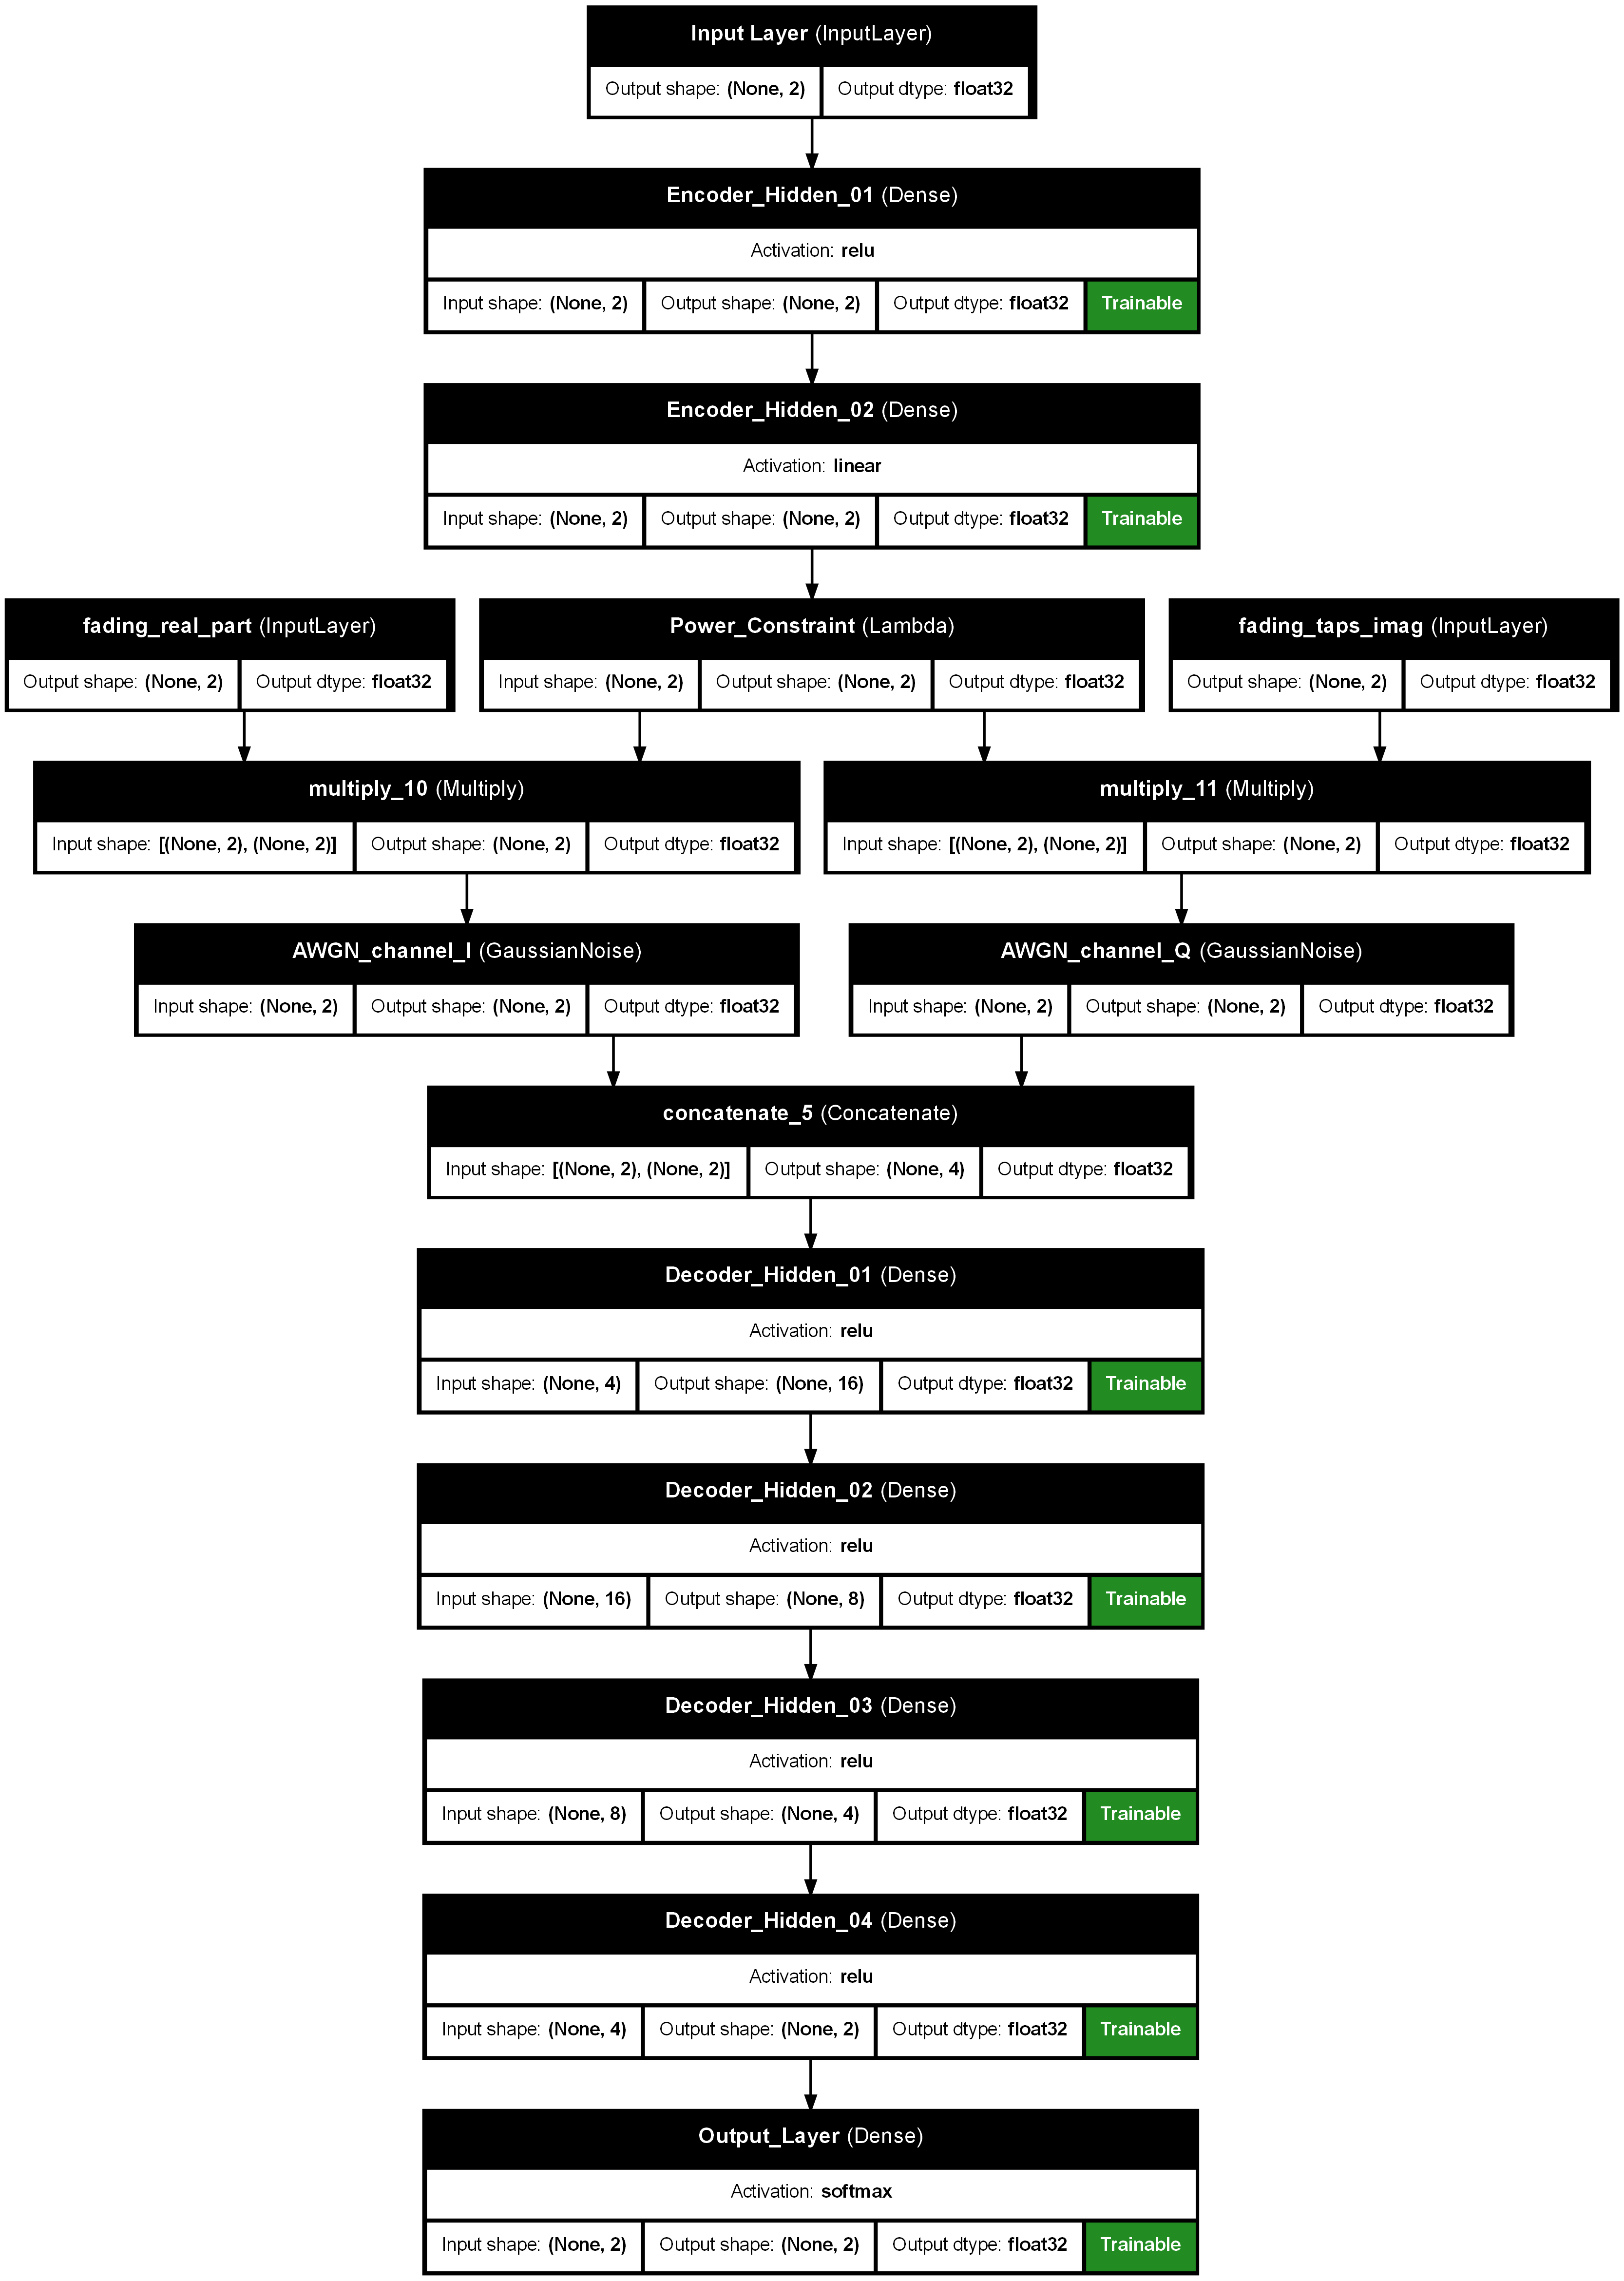

In [48]:
# To view the block diagram of the autoencoder
tf.keras.utils.plot_model(
    autoencoder,
    to_file='deepSISOnoCSI_noCoding.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [49]:
# Fitting the model by using the training set :
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5241 - loss: 0.6745
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9829 - loss: 0.1125
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0581
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9841 - loss: 0.0460
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9841 - loss: 0.0411
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0381
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0368
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0357
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9842 - loss: 0.0357
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0350
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9842 - loss: 0.0352
Epoch 12/100
1000/1

In [50]:
t1_train = time.time()

- Testing the above encoder at various SNRs

Generation of validation data 

In [51]:
testing_set_size = 10 ** 6 
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [52]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-6]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-5](decoder_output)
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [53]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * SNR_lin) 
encoded_samples = encoder_model.predict(x_test)
print(np.linalg.norm(encoded_samples) ** 2)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
999999.8779296912


In [54]:
np.shape(encoded_samples)

(1000000, 2)

In [55]:
with open("noCSImapping.txt", mode='w') as file_id:
    for i in range(50):
        if i == 0 :
            file_id.write(f'encoded_samples = {encoded_samples[i]},\n')
        else:
            file_id.write(f'{encoded_samples[i]},\n')

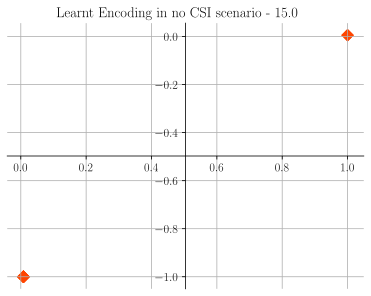

In [56]:
# Visualizing the lernt encoding : 
fig, axes = plt.subplots()
for i in range(10):
    axes.scatter(encoded_samples[i][0], encoded_samples[i][1], color='orangered', marker="D", s=2**6)
# Move left y-axis and bottom x-axis to centre, passing through (0,0)
axes.spines['left'].set_position('center')
axes.spines['bottom'].set_position('center')

# Eliminate upper and right axes
axes.spines['right'].set_color('none')
axes.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')
axes.grid()
axes.set_title(f'Learnt Encoding in no CSI scenario - {SNR_TRAIN}')
fig.savefig(f'noCSImapping_{SNR_TRAIN}.svg', transparent=True)

- We are restraining to using only BPSK mapping.

We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

In [57]:
BLER_learned_uncoded = []
count = 0 
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_uncoded.append(np.sum(estimated_vectors != y_test) / testing_set_size)
    count += 1 
    print(f'Progress : {100 * count / len(noise_var)} %')
t1_test = time.time()

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step
Progress : 3.3333333333333335 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
Progress : 6.666666666666667 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
Progress : 10.0 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
Progress : 13.333333333333334 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step
Progress : 16.666666666666668 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step
Progress : 20.0 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step
Progress : 23.333333333333332 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step
Progress : 26.666666666666668 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 48s 

### With Coding 

- System Parameters/ Definitions 

In [58]:
k = 4                       # Number of bits required
n = 7                       # Size of coded vector 
M = 2 ** k                  # Size of alphabet
R = k / n                   # Information/ Communication rate 

- Generation of training data

In [59]:
training_set_size = 10 ** 6  # Equivalent to k million bits

# Random indices 
sample_indices = np.random.randint(0, M, training_set_size)

# Random 1-hot encoded vectors
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'One Hot encoded vectors :{x_train}')
print(f'Input Shape :{np.shape(x_train)}')
# Since we are reproducing the input at the output :
y_train = x_train # Setting the labels as the inputs 

# Generate random fading tap samples for training
fading_mean = 0 
fading_std = np.sqrt(0.5)
# # Rayleigh Fading :
fading_taps_I = np.random.normal(fading_mean, fading_std, (training_set_size, 2*n)) 
fading_taps_Q = np.random.normal(fading_mean, fading_std, (training_set_size, 2*n))

One Hot encoded vectors :[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Input Shape :(1000000, 16)


- Creating the Autoencoder

In [60]:
# Description of the encoder(transmitter) part :
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
# enc_layer_02 = tf.keras.layers.Dense(2*n, activation='relu', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(2*n, activation='linear', name="Encoder_Hidden_03")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Describing the AWGN Channel with Rayleigh fading :
fading_layer_real = tf.keras.Input(shape=(2*n, ), name='fading_real_part')
fading_layer_imag = tf.keras.Input(shape=(2*n, ), name='fading_taps_imag')
# y = fx + w  model(flat + fast fading):
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Adding the Gaussian noise :
# SNR_TRAIN = float(input('Enter training SNR'))
SNR_lin = 10 ** (SNR_TRAIN / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * R * SNR_lin)), name='AWGN_channel_I')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (4 * R * SNR_lin)), name='AWGN_channel_Q')(rx_signal_imag)

# Description of the decoder part :
# Concatenating the real and imag noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag])
dec_layer_01 = tf.keras.layers.Dense(8*n, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_layer_04 = tf.keras.layers.Dense(1*M, activation='relu', name='Decoder_Hidden_04')(dec_layer_03)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_04)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 16)        │        272 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_03   │ (None, 14)        │        238 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 14)        │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_real_part    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_imag    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 14)        │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_real_part… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 14)        │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_taps_imag… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 14)        │          0 │ multiply_12[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 14)        │          0 │ multiply_13[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 28)        │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 56)        │      1,624 │ concatenate_6[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 64)        │      3,648 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 32)        │      2,080 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_04   │ (None, 16)        │        528 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 16)        │        272 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,662 (33.84 KB)

 Trainable params: 8,662 (33.84 KB)

 Non-trainable params: 0 (0.00 B)

- Training the autoencoder

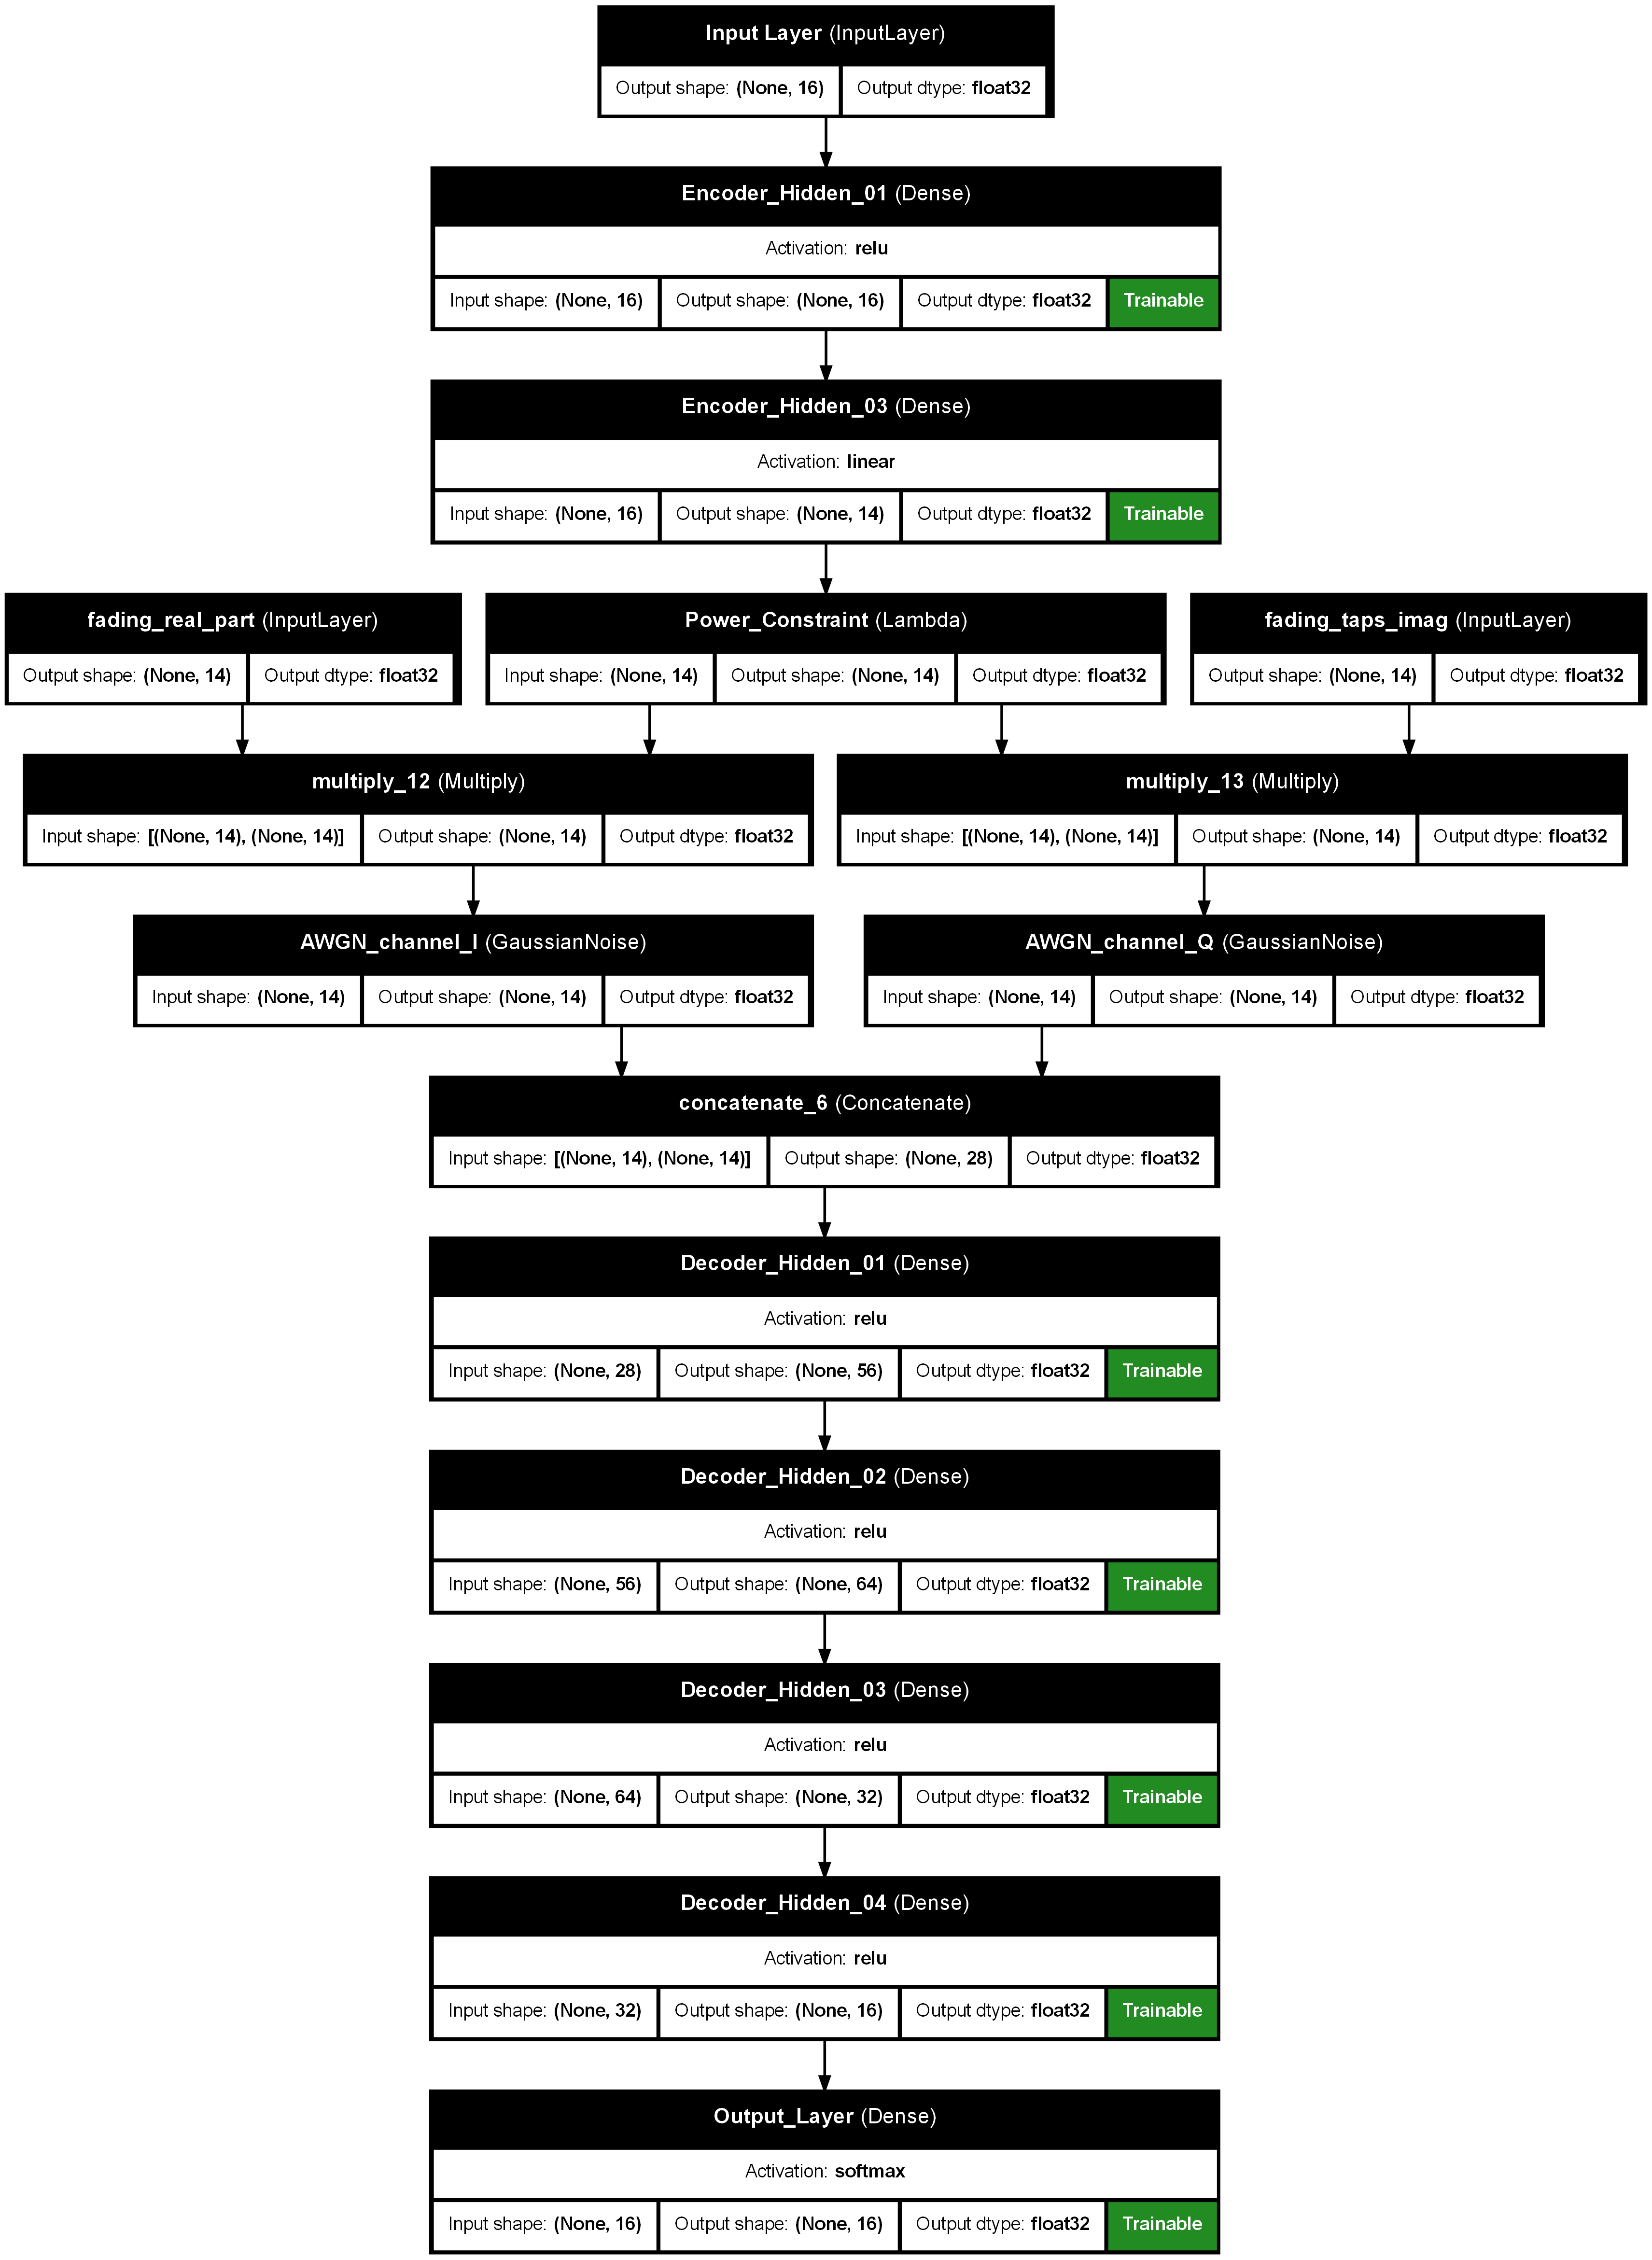

In [61]:
# To view the block diagram of the autoencoder
tf.keras.utils.plot_model(
    autoencoder,
    to_file='deepSISOnoCSI_Coding.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

In [62]:
autoencoder.fit([x_train, fading_taps_I, fading_taps_Q], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5716 - loss: 1.2639
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9622 - loss: 0.1155
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9786 - loss: 0.0661
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9834 - loss: 0.0514
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9865 - loss: 0.0421
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9882 - loss: 0.0369
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9894 - loss: 0.0327
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9904 - loss: 0.0298
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9913 - loss: 0.0268
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9917 - loss: 0.0258
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9923 - loss: 0.0238
Epoch 12/100
100

In [63]:
t2_train = time.time()

- Testing the above encoder at various SNRs

Generation of testing/ validation data 

In [64]:
testing_set_size = 10 ** 6
y_test = np.random.randint(0, M, testing_set_size)
x_test = np.zeros((testing_set_size, M))  
x_test[np.arange(testing_set_size), y_test] = 1  # One-hot encoding
print(x_test)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- Abstracting the encoder and decoder for use from the trained autoencoder

In [65]:
# Abstracting out the encoder model :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Codeword Received at the receiver :
rx_noisy_signal_I = tf.keras.Input(shape=(2*n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(2*n,))
decoder_output = autoencoder.layers[-6]([rx_noisy_signal_I, rx_noisy_signal_Q])
decoder_output = autoencoder.layers[-5](decoder_output)
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

# Abstracting out the decoder model :
decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q], decoder_output)

- Validation Routine

In [66]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of total noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 
print(np.linalg.norm(encoder_model.predict(x_test)) ** 2)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
6999803.15888077


In [67]:
BLER_learned_coded = []
count = 0
for noise in noise_var:
    # Encoding
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (testing_set_size, 2*n)) + 1j * np.random.normal(fading_mean, fading_std, (testing_set_size, 2*n))
    faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise/2), (testing_set_size, 2*n)) + 1j * np.random.normal(0, np.sqrt(noise/2), (testing_set_size, 2*n))
    noisy_signal = faded_signal + noise_samples
    # Decoding
    decoded_signal = decoder_model.predict([np.real(noisy_signal), np.imag(noisy_signal)])
    # Analysis
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_coded.append(np.sum(estimated_vectors != y_test) / testing_set_size)
    count += 1 
    print(f'Progress : {100 * count / len(noise_var)} %')
t2_test = time.time()

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
Progress : 3.3333333333333335 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 782us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step
Progress : 6.666666666666667 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 117s 4ms/step
Progress : 10.0 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 144s 5ms/step
Progress : 13.333333333333334 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step
Progress : 16.666666666666668 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 193s 6ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 435s 14ms/step
Progress : 20.0 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 162s 5ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 394s 13ms/step
Progress : 23.333333333333332 %
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 222s 7ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 311s 10ms/step
Progress : 26.666666666666668 %
31250/31250 ━━━━━━━━━━━━

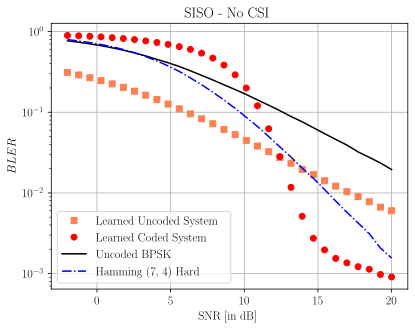

In [68]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family" : 'serif',
    "font.size": 12
})
# Benchmarks :
BLER_uncoded_ortho = [0.770032, 0.741072, 0.707516, 0.67044, 0.630716, 0.588684, 0.544384, 0.498856, 0.455832, 0.413468, 0.366864, 0.326608, 0.289568, 0.25318, 0.2202, 0.192124, 0.165788, 0.141792, 0.121876, 0.104848, 0.087996, 0.075568, 0.06366, 0.054288, 0.045144, 0.039016, 0.032344, 0.028524, 0.022732, 0.019944]
BLER_coded_ortho_hard = [0.795588, 0.765284, 0.731328, 0.690784, 0.648584, 0.599552, 0.545756, 0.490456, 0.433272, 0.374588, 0.319228, 0.268316, 0.221484, 0.179448, 0.14176, 0.112308, 0.08658, 0.065868, 0.050596, 0.037456, 0.027672, 0.020548, 0.01542, 0.011068, 0.008068, 0.005864, 0.004252, 0.003, 0.002192, 0.00152]
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_learned_uncoded, label='Learned Uncoded System', color='coral', marker='s', ls=" ")
axes.semilogy(SNR_dB, BLER_learned_coded, label='Learned Coded System', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_ortho, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_ortho_hard, label='Hamming (7, 4) Hard', color='blue', ls="-.")
axes.set_xlabel(f'SNR [in dB]')
axes.set_ylabel(r'$BLER$')
# axes.set_xlim(-3, 21)
# axes.set_ylim(10**-4, 10**0)
axes.set_title(f'SISO - No CSI')
axes.legend()
axes.grid(which='both')

In [69]:
# Saving the results for future reference :
# BLERs :
with open(f'deepSISOnoCSI_{SNR_TRAIN}.txt', mode='w') as file_id:
    file_id.write(f'BLER_learned_coded = {BLER_learned_coded}\n')
    file_id.write(f'BLER_learned_uncoded = {BLER_learned_uncoded}\n')
    file_id.write(f'BLER_uncoded_ortho = {BLER_uncoded_ortho}\n')
    file_id.write(f'BLER_coded_ortho_hard = {BLER_coded_ortho_hard}')

In [70]:
print(f'Summary....')
print(f'Number of testing set/training set size :{testing_set_size, training_set_size}')
print(f'Total execution time : {(time.time() - t0) / 60} mins')
print(f'Time for training uncoded system : {(t1_train - t0) / 60} mins')
print(f'Time for testing uncoded system : {(t1_test - t1_train) / 60} mins')
print(f'Time for training uncoded system : {(t2_train - t1_test) / 60} mins')
print(f'Time for testing uncoded system : {(t2_test - t2_train) / 60} mins')

Summary....
Number of testing set/training set size :(1000000, 1000000)
Total execution time : 235.7047080516815 mins
Time for training uncoded system : 4.352355511983236 mins
Time for testing uncoded system : 98.51501882076263 mins
Time for training uncoded system : 12.153313569227855 mins
Time for testing uncoded system : 120.66711394786834 mins
